## material

### paperswithcode

https://arxiv.org/pdf/1406.2661.pdf

[Link](https://paperswithcode.com/paper/improved-techniques-for-training-gans) to the paper on [paperswithcode.com](https://paperswithcode.com). <br>
[Link](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Improved_Techniques_for_Training_GANs) to the GitHub repository.

In [16]:
# standard libraries
import os
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({
	"font.size": 10,
	"font.family" : "serif",
	"pgf.texsystem": "pdflatex",
	"text.usetex": True,
})
def mnistshow(img):
	plt.imshow(img, cmap = "gray")
	plt.axis("off")
import seaborn as sns
sns.set(font = "serif", style = "whitegrid", palette = "dark:#5A9_r", font_scale = 0.75)

# progress bar
from tqdm import tqdm

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets

# set device (gpu or cpu)
gpu_flag = True
if gpu_flag:
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print("using device " + str(device) + ": ", end = "")
	if device.type == "cuda":
		print(torch.cuda.get_device_name(0), end = "")
		print(" (cuda version " + torch.version.cuda + ")")
else:
	device = torch.device("cpu")
	print("using device " + str(device))

# paths
images_path = "./data/images/"
models_path = "./data/models/"

using device cuda: NVIDIA GeForce GTX 1650 (cuda version 12.1)


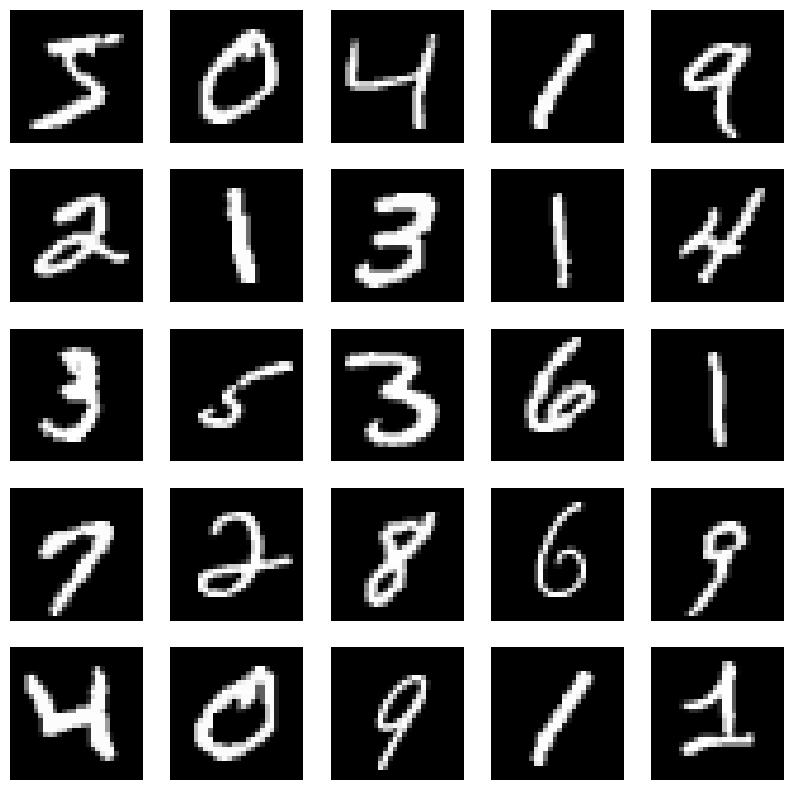

In [17]:
# import mnist dataset
train = datasets.MNIST(root = "./data", train = True, download = True, transform = None)
test = datasets.MNIST(root = "./data", train = False, download = True, transform = None)

# config train/test set
X_train = np.stack([np.array(train[i][0]) for i in range(len(train))], axis = 0)
y_train = np.stack([np.array(train[i][1]) for i in range(len(train))], axis = 0)
X_test = np.stack([np.array(test[i][0]) for i in range(len(test))], axis = 0)
y_test = np.stack([np.array(test[i][1]) for i in range(len(test))], axis = 0)

# head of mnist dataset
head_len = 25
plt.figure(figsize = (10, 10))
for i in range(head_len):
	plt.subplot(int(np.sqrt(head_len)), int(np.sqrt(head_len)), 1 + i)
	mnistshow(X_train[i])
if os.path.isfile(images_path + "head_mnist_data.pdf"):
	os.remove(images_path + "head_mnist_data.pdf")
plt.savefig(images_path + "head_mnist_data.pdf")
plt.show()

In [18]:
# seed
seed = 1
torch.manual_seed(seed)

image_dim = 28 * 28

# generator
gen_input_dim = 100
gen_hidden_dim = 1200
class generator_model(nn.Module):
	def __init__(self, input_dim = gen_input_dim, hidden_dim = gen_hidden_dim, output_dim = image_dim):
		super(generator_model, self).__init__()
		self.network = nn.Sequential(
			nn.Linear(input_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, output_dim),
			nn.Tanh(),
		)
	def forward(self, input):
		return self.network(input)

# discriminator
disc_hidden_dim = 240
class discriminator_model(nn.Module):
	def __init__(self, input_dim = image_dim, hidden_dim = disc_hidden_dim, output_dim = 1):
		super(discriminator_model, self).__init__()
		self.network = nn.Sequential(
			nn.Linear(input_dim, hidden_dim),
			nn.LeakyReLU(negative_slope = 0.2),
			nn.Linear(hidden_dim, hidden_dim),
			nn.LeakyReLU(negative_slope = 0.2),
			nn.Linear(hidden_dim, output_dim),
			nn.Sigmoid(), 
		)
	def forward(self, x):
		return self.network(x)
	
def get_minibatch(data, batch_size):
	"""
	description
		it creates a vector of random entries of data with lenght batch_size (uniformly selected)
	input
		data	 	:= training dataset
		batch_size	:= size of the minibatch
	output
		minibatch	:= minibatch randomly built
	syntax
		minibatch = get_minibatch(data, batch_size)
	"""
	indices = torch.randperm(data.shape[0])[:batch_size]
	return torch.tensor(data[indices], dtype = torch.float).reshape(batch_size, -1)

def sample_noise(size, dim = 100):
	"""
	description
		it creates a tensor size x dim of gaussian noise to use as input for the generative net
	input
		size	:= input size of the generative net
		dim		:= number of input data to generate
	output
		noise	:= noise tensor
	syntax
		noise = sample_noise(size, dim)
	"""
	out = torch.empty(size, dim)
	mean = torch.zeros(size, dim)
	std = torch.ones(dim)
	torch.normal(mean, std, out = out)
	return out

def train(generator, discriminator, generator_optimizer, discriminator_optimizer, data, k = 1, batch_size = 100, n_epochs = 50000):
	"""
	description
		training algorithm for the generative adversarial net: we alternate between k steps of optimizing D and one step of optimizing G.
		it returns the two loss functions for G and D.
	input
		generator, discriminator, generator_optimizer, discriminator_optimizer
		data		:= input data to train the gan
		k 			:= number of steps of optimization of D alternated to one step of optimization of G
		batch_size	:= minibatch size for the stochastic gradient descent
		n_epochs	:= number of epochs for the training
	output
		loss = train(generator, discriminator, generator_optimizer, discriminator_optimizer)
	"""
	loss_function = {"generator": [], "discriminator": []}
	
	for _ in tqdm(range(n_epochs), desc = "progress"):

		# train disciminator (k steps)
		for _ in range(k):
			# sample minibatch of m noise samples, z 
			z = sample_noise(batch_size).to(device)
			# sample minibatch of m examples, x,  from data generating process
			x = get_minibatch(data, batch_size).to(device)
			# update the discriminator by ascending its stochastic gradient
			#	- loss computation
			#	- reset discriminator_optimizer gradients
			#	- compute gradients
			#	- SGD step
			generator_loss = nn.BCELoss()(
				discriminator(generator(z)).reshape(batch_size),
				torch.zeros(batch_size, device = device))
			discriminator_loss = nn.BCELoss()(
				discriminator(x).reshape(batch_size),
				torch.ones(batch_size, device = device))
			loss = (generator_loss + discriminator_loss) / 2
			discriminator_optimizer.zero_grad()
			loss.backward()
			discriminator_optimizer.step()
			loss_function["discriminator"].append(loss.item())

		# train generator (1 step)
		# sample minibatch of m noise samples
		z = sample_noise(batch_size).to(device)
		# update the generator by descending its stochastic gradient
		#	- loss computation
		#	- reset generator_optimizer gradients
		#	- compute gradients
		#	- SGD step
		generator_loss = nn.BCELoss()(
			discriminator(generator(z)).reshape(batch_size),
			torch.ones(batch_size, device = device))
		generator_optimizer.zero_grad()
		generator_loss.backward()
		generator_optimizer.step()
		loss_function["generator"].append(generator_loss.item())

	return loss_function

In [19]:
# parameters
#	- if load: load a pre-trained model
#	- if train: train a new model
#	- if save: save the current model
#	- if optim_algo == "sgd": optimization with sgd
#	  elif optim_algo == "adam": optimization with adam
load_flag = False
train_flag = True
save_flag = False
optim_algo = "sgd"
n_epochs = 10000

progress: 100%|██████████| 10000/10000 [02:41<00:00, 62.10it/s]


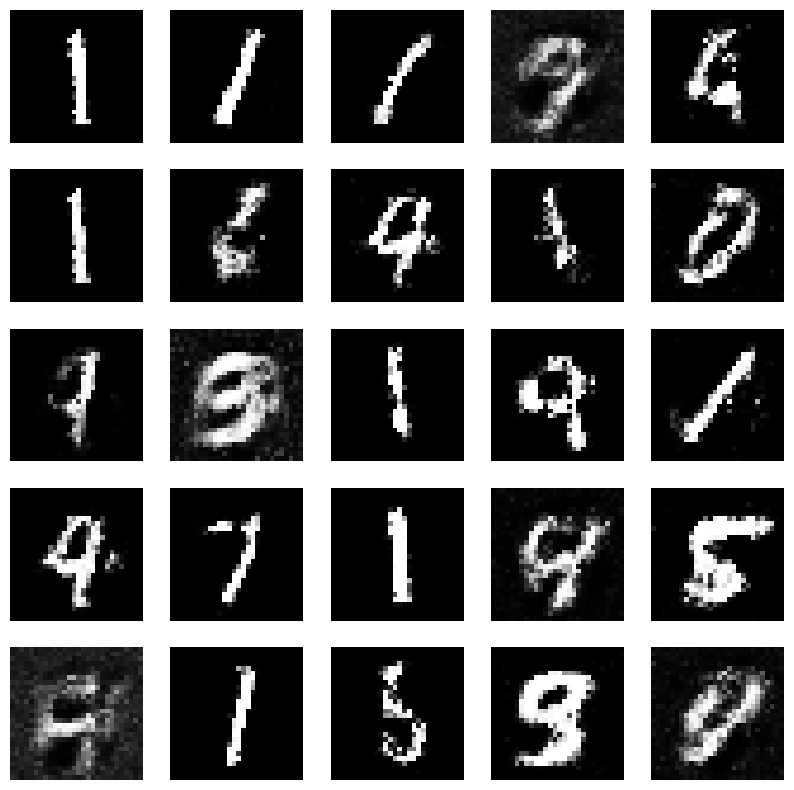

In [20]:
# normalize mnist dataset
#	- original: 	[0, 255]
#	- normalized:	[-1, 1]
X_train = (np.float32(X_train) - 127.5) / 127.5

# init generator/discriminator
generator = generator_model().to(device)
discriminator = discriminator_model().to(device)
if optim_algo == "sgd":
	generator_optimizer = optim.SGD(generator.parameters(), lr = 0.1, momentum = 0.5)
	discriminator_optimizer = optim.SGD(discriminator.parameters(), lr = 0.1, momentum = 0.5)
elif optim_algo == "adam":
	generator_optimizer = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
	discriminator_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

# load generator/discriminator (if there is a save)
load_flag = load_flag and os.path.isfile(models_path + "generator") and os.path.isfile(models_path + "generator_optimizer") and \
	os.path.isfile(models_path + "discriminator") and os.path.isfile(models_path + "discriminator_optimizer")
if load_flag:
	generator.load_state_dict(torch.load(models_path + "generator"))
	generator_optimizer.load_state_dict(torch.load(models_path + "generator_optimizer"))
	discriminator.load_state_dict(torch.load(models_path + "discriminator"))
	discriminator_optimizer.load_state_dict(torch.load(models_path + "discriminator_optimizer"))

# train generator/discriminator
if train_flag:
	loss = train(generator, discriminator, generator_optimizer, discriminator_optimizer, X_train, n_epochs = n_epochs)

# real number of training epochs
old_n_epochs = 0
if not(train_flag):
	n_epochs = 0
if load_flag:
	info_old = open(models_path + "info.txt", "r")
	old_n_epochs = int(info_old.readlines()[1][len("n_epochs = "):])
n_epochs = n_epochs + old_n_epochs

# generate and plot n_images samples with the generator
n_images = 25
z = sample_noise(n_images).to(device)
x = generator(z)
plt.figure(figsize = (10, 10))
for i in range(n_images):
	plt.subplot(int(np.sqrt(n_images)), int(np.sqrt(n_images)), 1 + i)
	mnistshow(x[i].data.cpu().numpy().reshape(28, 28))
if os.path.isfile(images_path + "regenerated_mnist_data_" + str(n_epochs) + ".pdf"):
	os.remove(images_path + "regenerated_mnist_data_" + str(n_epochs) + ".pdf")
plt.savefig(images_path + "regenerated_mnist_data_" + str(n_epochs) + ".pdf")
plt.show()

# save generator/discriminator
if save_flag:
	torch.save(generator.state_dict(), models_path + "generator")
	torch.save(generator_optimizer.state_dict(), models_path + "generator_optimizer")
	torch.save(discriminator.state_dict(), models_path + "discriminator")
	torch.save(discriminator_optimizer.state_dict(), models_path + "discriminator_optimizer")
	info = open(models_path + "info.txt", "w")
	info.write("optimization = " + str(optim_algo) + "\n" + "n_epochs = " + str(n_epochs))
	info.close()

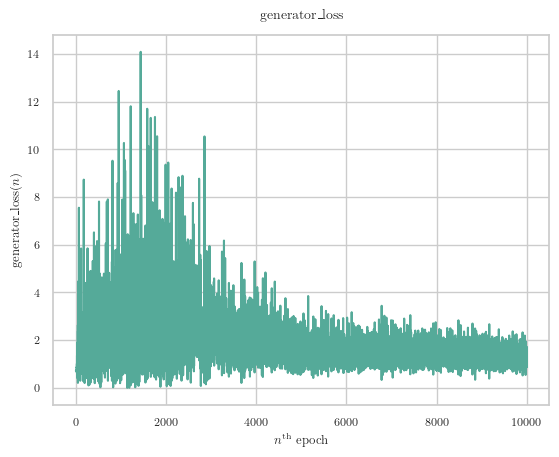

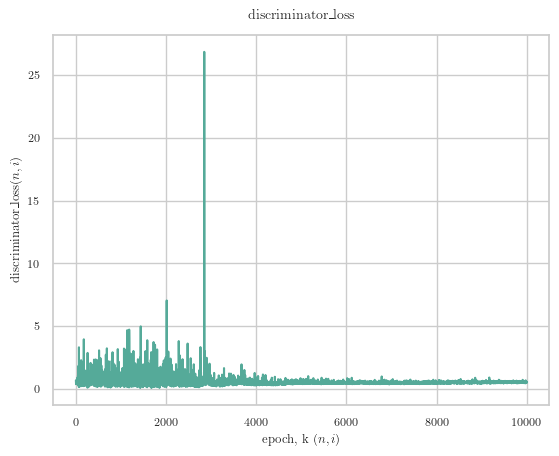

In [21]:
if train_flag:
	# plot generator loss
	g_loss = sns.lineplot(x = range(len(loss["generator"])), y = loss["generator"])
	g_loss.set_title("generator_loss", weight = "bold", y = 1.02).set_fontsize("10")
	g_loss.set_xlabel("$n^{\\mathrm{th}}$ epoch")
	g_loss.set_ylabel("generator_loss$(n)$")
	fig_g = g_loss.get_figure()
	# fig_g.savefig(images_path + "generator_loss.pdf")
	plt.show()
	# plot discriminator loss
	d_loss = sns.lineplot(x = range(len(loss["discriminator"])), y = loss["discriminator"])
	d_loss.set_title("discriminator_loss", weight = "bold", y = 1.02).set_fontsize("10")
	d_loss.set_xlabel("epoch, k $(n, i)$")
	d_loss.set_ylabel("discriminator_loss$(n, i)$")
	fig_d = d_loss.get_figure()
	# fig_d.savefig(images_path + "discriminator_loss.pdf")
	plt.show()